# G2M insight for Cab investment firm-Prediction

## Brennan Clinch

Company Objective: XYZ is a private business firm located in the US. XYZ is wanting to invest in the Cab industry. The 2 main companies it is comparing are Pink Cab and Yellow Cab. XYZ needs our help with determining which of the 2 companies would be better to invest in. From our previous EDA, we have decided that Yellow Cab would be the better company to invest in. However, we will like to know what direction the profit being made could go in 2019. So we would like to create an interpretable model that would forecast the amount of Profit being made by both companies for 2019.

Goal: Forecast Profit in 2019 using machine learning and ensemble techniques

### Import Data and Libraries

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import sklearn as sl

In [2]:
# Import Data
CabData = pd.read_csv('C:\\Users\\JCCLI\\Downloads\\Cab_Data.csv')

# Read in City data and convert to csv
City = pd.read_csv('C:\\Users\\JCCLI\\Downloads\\City.csv')

# Read in Customer ID data and convert to csv
CustomerID = pd.read_csv('C:\\Users\\JCCLI\\Downloads\\Customer_ID.csv')

# Read in Transaction ID data and convert to csv
TransactionID = pd.read_csv('C:\\Users\\JCCLI\\Downloads\\Transaction_ID.csv')




### Data Wrangling and adding variables from EDA

In [3]:
# Merge the files together
Transactionmerge = CabData.merge(TransactionID, on = "Transaction ID")
Customermerge = Transactionmerge.merge(CustomerID, on = "Customer ID")
Cab = Customermerge.merge(City, on = "City")


In [4]:
# Modify variables
Cab['City']=Cab['City'].apply(lambda x: x.title())
Cab['Population'] = Cab['Population'].apply(lambda x: x.replace(",",""))
Cab['Population'] = Cab['Population'].astype('int64')

Cab['Users'] = Cab['Users'].apply(lambda x: x.replace(",",""))
Cab['Users'] = Cab['Users'].astype('int64')

In [5]:
# Create new categorical variable to dataset breaking up age into segments. 18-19 late teens, 20-29 20's, 30-39 30's, 
# 40-49 40's, 50-59 50's, 60's + Seniors'

def func(age):
    if 18 <= age <= 19:
        return 'Late Teens'
    elif 19 < age <= 29:
        return '20s'
    elif 29 < age <= 39:
        return '30s'
    elif 39 < age <= 49:
        return '40s'
    elif 49 < age <= 59:
        return '50s'
    else:
        return 'Seniors'

Cab['Age_Group'] = Cab['Age'].apply(func)

In [6]:
Cab.rename(columns={'Date of Travel':'Date'},inplace=True)

In [7]:
from datetime import datetime
Cab['Date'] =  pd.to_datetime(Cab['Date'], infer_datetime_format=True)

In [8]:
import datetime as dt
# Create new columns based on day, month, and year
Cab['Year'] = Cab['Date'].dt.year
Cab['Month'] = Cab['Date'].dt.month
Cab['Day'] = Cab['Date'].dt.day
Cab['Day of Week'] = Cab['Date'].dt.day_name()

# Create Season Variable

def func(Month):
    if 1 <= Month <= 2:
        return 'Winter'
    elif 3 <= Month <= 5:
        return 'Spring'
    elif 6 <= Month <= 8:
        return 'Summer'
    elif 9 <= Month <= 12:
        return 'Fall'
    
Cab['Season'] = Cab['Month'].apply(func)

In [9]:
Cab['Profit'] = Cab['Price Charged'] - Cab['Cost of Trip']
Cab['Profit to KM Ratio'] = Cab['Profit']/Cab['KM Travelled']
Cab['Cost per KM'] = Cab['Cost of Trip']/Cab['KM Travelled']
Cab['Profit to Price Ratio'] = Cab['Profit']/Cab['Price Charged']
Cab['User to Population Ratio'] = Cab['Users']/Cab['Population']

### Modeling
- Our goal for modeling is to create a model that will forecast future profit for both Cab companies
- The criteria for selection that we will be wanting will be MAE along with GOF. But mostly it will be MAE.
- Let's begin our modeling for our data by creating new binary variables to be used in the prediction

In [71]:
# Create dummy variables/change some variables to factors

Cab['Company is Yellow Cab'] = np.where(Cab['Company'].isin(['Yellow Cab']),1,0)
Cab['Company is Pink Cab'] = np.where(Cab['Company'].isin(['Pink Cab']),1,0)
Cab['Card'] = np.where(Cab['Payment_Mode'].isin(['Card']),1,0)
Cab['Cash'] = np.where(Cab['Payment_Mode'].isin(['Card']),1,0)
Cab['Sex_ismale'] =  np.where(Cab['Gender'].isin(['Male']),1,0)
Cab['Sex_isfemale'] = np.where(Cab['Gender'].isin(['Female']),1,0)
Cab['Company is Pink Cab'] = Cab['Company is Pink Cab'].astype('category')
Cab['Card'] = Cab['Card'].astype('int64')
Cab['Sex_ismale'] = Cab['Sex_ismale'].astype('category')
Cab['Sex_isfemale'] = Cab['Sex_isfemale'].astype('category')


def func(Season):
    if Season == 'Winter':
        return 1
    elif Season == 'Spring':
        return 2
    elif Season == 'Summer':
        return 3
    else:
        return 4
Cab['Season_code'] = Cab['Season'].apply(func)
Cab['Season_code'] = Cab['Season_code'].astype('category')

Cab['Weekend'] = np.where(Cab['Day of Week'].isin(['Friday','Saturday','Sunday']),1,0)

In [13]:
# City ID Variable to be used in modeling
cities = [
    (Cab["City"]=='Atlanta Ga'),
    (Cab["City"]=='Austin Tx'),
    (Cab["City"]=='Boston Ma'),
    (Cab["City"]=='Chicago Il'),
    (Cab["City"]=='Dallas Tx'),
    (Cab["City"]=='Denver Co'),
    (Cab["City"]=='Los Angeles Ca'),
    (Cab["City"]=='Miami Fl'),
    (Cab["City"]=='Nashville Tn'),
    (Cab["City"]=='New York Ny'),
    (Cab["City"]=='Orange County'),
    (Cab["City"]=='Phoenix Az'),
    (Cab["City"]=='Pittsburgh Pa'),
    (Cab["City"]=='Sacramento Ca'),
    (Cab["City"]=='San Diego Ca'),
    (Cab["City"]=='Seattle Wa'),
    (Cab["City"]=='Silicon Valley'),
    (Cab["City"]=='Tucson Az'),
    (Cab["City"]=='Washington Dc'),
    
]
Citycodes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]

Cab["City ID"] = np.select(cities, Citycodes)

In [73]:
## Outlier Removal
Cabnew = Cab[(Cab['Profit'] < 576.03) & (Cab['Profit'] > -220)]

#### Train-Test Split
- We are wanting to create and compare machine learning along with logistic regression models predicting the odds of a user choosing one company over the other along with models for the payment method. From these models we can determine which variables have the most effect in the prediction as well
- To reduce bias with our modeling, we need to split up our data into a training set and test set
- 75% of the data will go to the training set while the other 25% will be used for testing

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

feature_columns = ['Income (USD/Month)','Profit to KM Ratio', 'Profit to Price Ratio', 'Weekend','Month','City ID',
                   'User to Population Ratio','Company is Yellow Cab', 'Card']
feat = Cabnew[feature_columns]
target = Cabnew['Profit']

x_train, x_test, y_train, y_test = train_test_split(feat , target , test_size= 0.25 , random_state=44)
print("Train",x_train.shape,y_train.shape)
print("Test",x_test.shape,y_test.shape)

Train (262327, 9) (262327,)
Test (87443, 9) (87443,)


#### Linear Regression: Profit

In [75]:
# importing module
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
# creating an object of LinearRegression class
LR = LinearRegression()
# fitting the training data
LR = LR.fit(x_train,y_train)
y_pred = LR.predict(x_test)
y_pred_train = LR.predict(x_train)
LR.score(x_train, y_train)
print("GOF:", LR.score(x_test,y_test))
print("MSE:",mean_squared_error(y_test,y_pred))
print("MAE:",mean_absolute_error(y_test,y_pred))
print("Train MAE:", mean_absolute_error(y_train, y_pred_train))

GOF: 0.5638547128520299
MSE: 7250.555248287726
MAE: 58.840388370485854
Train MAE: 59.038804616284935


#### Regression Tree: Profit


In [76]:
from sklearn.tree import DecisionTreeRegressor 
Regressor = DecisionTreeRegressor(random_state =20,criterion = "squared_error", max_depth = 8)

# Train Decision Tree Classifer
Regressor = Regressor.fit(x_train,y_train)

#Predict the response for test dataset
y_pred = Regressor.predict(x_test)
y_predtrain = Regressor.predict(x_train)
MAE = mean_absolute_error(y_test, y_pred)
MAEt = mean_absolute_error(y_train,y_predtrain)
print("GOF:",Regressor.score(x_test,y_test))
print("Train MAE: {:.3f}".format(MAEt))
print("MAE: {:.3f}".format(MAE))

GOF: 0.5766544116687982
Train MAE: 57.441
MAE: 57.650


#### Random Forest

In [77]:
from sklearn.ensemble import RandomForestRegressor as rfr
rf_model = rfr(n_estimators=100, criterion='squared_error', random_state = 16, max_depth = 7)
rf_model = rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)
y_predtrain = rf_model.predict(x_train)
from sklearn import metrics
rf_model.score(x_test, y_test)
MAE = mean_absolute_error(y_test, y_pred)
MAEt = mean_absolute_error(y_train,y_predtrain)
print("GOF:", rf_model.score(x_test,y_test))
print("Train MAE: {:.3f}".format(MAEt))
print("MAE: {:.3f}".format(MAE))

GOF: 0.5796243376002388
Train MAE: 57.519
MAE: 57.516


#### Boosted Tree


In [79]:
from xgboost import XGBRegressor
from pandas import MultiIndex, Int64Index
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
Boostmodel = XGBRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(Boostmodel, x_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

C:\Users\JCCLI\AppData\Local\Temp\ipykernel_13044\2271623326.py:2: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [80]:
from numpy import absolute
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 57.978 (0.371)


#### Variable importance and correlation

Feature: 0, Score: -0.00001
Feature: 1, Score: 9.46229
Feature: 2, Score: 263.79044
Feature: 3, Score: -1.05152
Feature: 4, Score: 0.22121
Feature: 5, Score: 0.16676
Feature: 6, Score: -28.28519
Feature: 7, Score: 11.50322
Feature: 8, Score: 0.14699


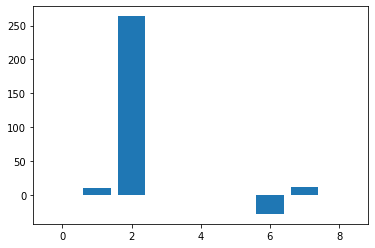

In [88]:
## Linear Regression
from matplotlib import pyplot
#### Variable Importance
importance = LR.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Feature: 0, Score: 0.00126
Feature: 1, Score: 0.99685
Feature: 2, Score: 0.00117
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00039
Feature: 5, Score: 0.00014
Feature: 6, Score: 0.00019
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


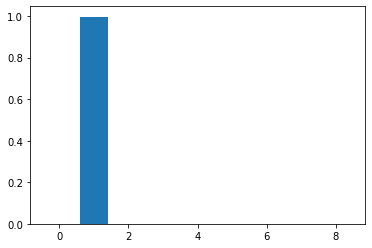

In [89]:
### Regression Tree
importance = Regressor.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Feature: 0, Score: 0.00129
Feature: 1, Score: 0.99648
Feature: 2, Score: 0.00142
Feature: 3, Score: 0.00004
Feature: 4, Score: 0.00028
Feature: 5, Score: 0.00019
Feature: 6, Score: 0.00023
Feature: 7, Score: 0.00001
Feature: 8, Score: 0.00005


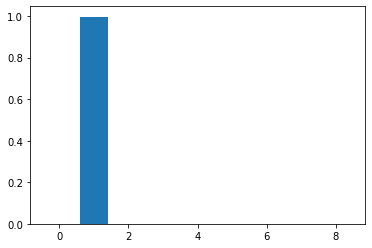

In [90]:
#### Random Forest
importance = rf_model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

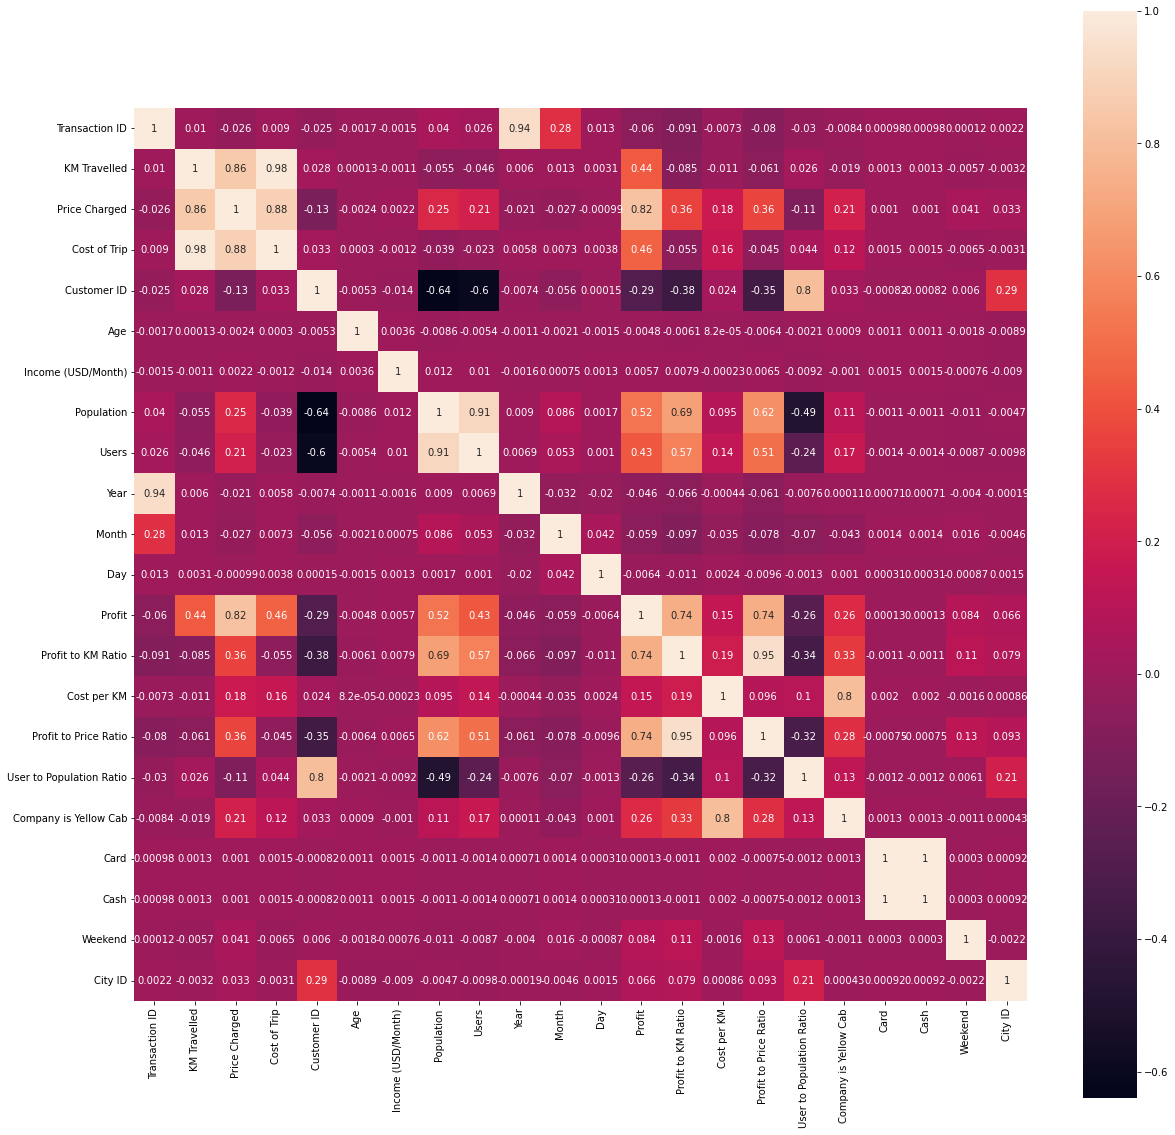

In [84]:
#### Correlation
plt.figure(figsize=(20,20))
corr = Cabnew.corr()
sns.heatmap(corr, annot=True, square=True)
plt.yticks(rotation=0)
plt.show()

## Conclusions
- Overall, the best model we got after tuning the hyperparameters was the Random Forest Model since it had the lowest MAE and the least difference between the MAE for training and testing to avoid overfitting
- Based on the variable importance plot and correlation plot, the key variables that have the most impact on the amount of profit for both companies are Customer ID, Profit To KM Ratio, Cost of Trip, KM Travelled, Price Charged, Population, Users, Profit to KM Ratio, Profit to Price Ratio, and Month

In [ ]:
### Deploy pickle model
import pickle
pickle.dump(DT_model, open('C://Users//JCCLI//Downloads//Treemodel.pickle', 'wb'))